In [43]:
import pandas as pd
import numpy as np
import nltk
import os
import nltk.corpus
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
import matplotlib.pyplot as plt
import re
from collections import defaultdict

#I used a mac but you may have to change the installation code below for Windows. 
!pip install geopandas 
!pip install folium
import geopandas
import folium

from shapely.geometry import Point

import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar , ContinuousColorMapper, LogColorMapper , ColumnDataSource
from bokeh.palettes import brewer
from bokeh.models import HoverTool
from bokeh.palettes import Spectral6
from bokeh.transform import linear_cmap

plt.style.use('ggplot')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

dice = pd.read_csv('dice_com-job_us_sample.csv')
google = pd.read_csv('job_skills.csv')

#lets import a file with longitude and Latitude of US-cities
uscities_longlat =  pd.read_csv('uscities original.csv')

#file with popoulation by state & Geo codes
datafile = 'state_population.csv'

#shapefile for US states & provinces  - need all the files in the subfolder -ne_110m_admin_1_states_provinces 
#shapefile = "C:/Users/Arvind Bhaskar/Documents/R_GSB_Sep2019/011_final project/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"
shapefile = "ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hikaru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
dice.head()

,advertiserurl,company,employmenttype_jobstatus,jobdescription,jobid,joblocation_address,jobtitle,postdate,shift,site_name,skills,uniq_id
0,https://www.dice.com/jobs/detail/AUTOMATION-TE...,"Digital Intelligence Systems, LLC","C2H Corp-To-Corp, C2H Independent, C2H W2, 3 M...",Looking for Selenium engineers...must have sol...,Dice Id : 10110693,"Atlanta, GA",AUTOMATION TEST ENGINEER,1 hour ago,Telecommuting not available|Travel not required,NaN,SEE BELOW,418ff92580b270ef4e7c14f0ddfc36b4
1,https://www.dice.com/jobs/detail/Information-S...,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,Dice Id : 10114469,"Chicago, IL",Information Security Engineer,1 week ago,Telecommuting not available|Travel not required,NaN,"linux/unix, network monitoring, incident respo...",8aec88cba08d53da65ab99cf20f6f9d9
2,https://www.dice.com/jobs/detail/Business-Solu...,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...",Dice Id : CXGALXYS,"Schaumburg, IL",Business Solutions Architect,2 weeks ago,Telecommuting not available|Travel not required,NaN,"Enterprise Solutions Architecture, business in...",46baa1f69ac07779274bcd90b85d9a72
3,https://www.dice.com/jobs/detail/Java-Develope...,TransTech LLC,Full Time,Java DeveloperFull-time/direct-hireBolingbrook...,Dice Id : 10113627,"Bolingbrook, IL","Java Developer (mid level)- FT- GREAT culture,...",2 weeks ago,Telecommuting not available|Travel not required,NaN,Please see job description,3941b2f206ae0f900c4fba4ac0b18719
4,https://www.dice.com/jobs/detail/DevOps-Engine...,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,Dice Id : matrixga,"Atlanta, GA",DevOps Engineer,48 minutes ago,Telecommuting not available|Travel not required,NaN,"Configuration Management, Developer, Linux, Ma...",45efa1f6bc65acc32bbbb953a1ed13b7


In [45]:
jd = dice['jobdescription'].apply(lambda x: len(str(x).split(" ")))
jd.mean()
#This gives us the word count in the first 5 jds. Here, I define word as anything in between two spaces. 

306.55654545454547

In [46]:
dice['jobdescription'].max()
#The maximum "word" count in the job description is 3455

'\uf0b7Technical consultant for Large Digital Asset Management(DAM) Product implementations\uf0b7Extensive hands-on experience in Digital Asset Management Tools like Opentext MediaManagement, Autonomy/HP Mediabin. Content Management tools like HP/AutonomyTeamsite, opendeploy, imaging tools like Imagemagick, exiftool, Ghostscript etc\uf0b7Highly Proficient in architectural design, set up and performance tuning of Digital assetmanagement tools for large Enterprise.\uf0b7Proficient in building Java-J2EE applications using various frameworks – Springs, struts.\uf0b7Strong knowledge on build tools like ant, maven, gradle.\uf0b7Extensive experience in web application servers - JBOSS, Apache Tomcat, TOMEE, IIS\uf0b7Experience in integrating Digital Management products with search technology likeApache Solr, Autonomy IDOL\uf0b7Proficient in Unix/Linux shell scripting, MSSQL, Oracle, PostgreSQL, Tandem.\uf0b7Work experience in key SDLC methodologies like Waterfall, Agile/Scrum.\uf0b7Strong busi

In [47]:
#Now let's look at term frequency. 
#Term Frequency = (# of times term appears in the particular row)/(# of terms in that row)
tf1 = (dice['jobdescription'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1.head()
#Inverse Document Frequency
#IDF = log(N/n), 
#where N is the total # of rows and n is the # of rows in which the word was present. 
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(dice.shape[0]/(len(dice[dice['jobdescription'].str.contains(word)])))
tf1.head()
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1.head()

,words,tf,idf,tfidf
0,and,13,0.020574,0.267460
1,of,11,0.041864,0.460506
2,the,8,0.083283,0.666262
3,or,7,0.010923,0.076462
4,Security,7,2.297145,16.080018


In [48]:
#Now lets look at the character count of the jobdescriptions. 
dice['char_count'] = dice['jobdescription'].str.len() ## this also includes spaces
dice[['jobdescription','char_count']].head()
#The average jd character count is 2295 characters. 

,jobdescription,char_count
0,Looking for Selenium engineers...must have sol...,3526
1,The University of Chicago has a rapidly growin...,2158
2,"GalaxE.SolutionsEvery day, our solutions affec...",2787
3,Java DeveloperFull-time/direct-hireBolingbrook...,2469
4,Midtown based high tech firm has an immediate ...,982


In [49]:
dice['char_count'].max()
#The max character count is 24382

24382

In [50]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

dice['avg_word'] = dice['jobdescription'].apply(lambda x: avg_word(x))
dice[['jobdescription','avg_word']].head()

,jobdescription,avg_word
0,Looking for Selenium engineers...must have sol...,5.676136
1,The University of Chicago has a rapidly growin...,6.561404
2,"GalaxE.SolutionsEvery day, our solutions affec...",6.149100
3,Java DeveloperFull-time/direct-hireBolingbrook...,6.014245
4,Midtown based high tech firm has an immediate ...,5.907801


In [51]:
#Now lets clean the text data. 

#First I used the astype(str) command to turn the data into datatype string so that we can apply our NLP methods. 
#The second step is to transform our jds into lower case. 
#This avoids having multiple copies of the same words. 
dice['jobdescription'] = dice['jobdescription'].astype(str).apply(lambda x: " ".join(x.lower() for x in x.split()))
dice['jobdescription'].head()

0    looking for selenium engineers...must have sol...
1    the university of chicago has a rapidly growin...
2    galaxe.solutionsevery day, our solutions affec...
3    java developerfull-time/direct-hirebolingbrook...
4    midtown based high tech firm has an immediate ...
Name: jobdescription, dtype: object

In [52]:
#The next step is to remove punctuation. 
dice['jobdescription'] = dice['jobdescription'].str.replace('[^\w\s]','')
dice['jobdescription'].head()

0    looking for selenium engineersmust have solid ...
1    the university of chicago has a rapidly growin...
2    galaxesolutionsevery day our solutions affect ...
3    java developerfulltimedirecthirebolingbrook il...
4    midtown based high tech firm has an immediate ...
Name: jobdescription, dtype: object

In [53]:
#Next remove stop words (or commonly occurring words) 
stop = stopwords.words('english')
dice['jobdescription'] = dice['jobdescription'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
dice['jobdescription'].head()

0    looking selenium engineersmust solid java codi...
1    university chicago rapidly growing security pr...
2    galaxesolutionsevery day solutions affect peop...
3    java developerfulltimedirecthirebolingbrook il...
4    midtown based high tech firm immediate need in...
Name: jobdescription, dtype: object

In [54]:
#Next lets see if we can clean some more by checking the top 50 most frequently occurring 
#generic words and then decide whether to remove or retain.
freq = pd.Series(' '.join(dice['jobdescription']).split()).value_counts()[:50]
freq

experience       74793
business         36489
development      33233
work             32602
years            28686
data             28235
skills           27754
management       27375
team             26652
technical        24471
software         24323
design           22899
project          22593
support          22518
systems          22196
knowledge        21031
solutions        19051
ability          17311
services         17038
working          16273
technology       16184
including        16063
security         15961
requirements     15820
required         14573
new              14543
strong           14536
application      14432
client           14183
information      13909
system           13655
applications     12861
position         12839
web              12537
environment      12029
must             11941
job              11569
testing          11492
communication    11316
related          11091
test             11003
network          10898
tools            10747
projects   

In [55]:
#These words are all very generic and are more "noise" than "signal". 
#It is worth noting however, that "data", "software", "security", "web", and "application"
#are top words. However, this is to be expected from the tech sector. 
#We will exclude the top 50 words for job description words from our analysis

#Similarly, we can remove rarely occurring words if we want with the code below
#freq = pd.Series(' '.join(dice['jobdescription']).split()).value_counts()[-10:]
#freq
#freq = list(freq.index)
#dice['jobdescription'] = dice['jobdescription'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
#dice['jobdescription'].head()

In [56]:
#Now that we have defined all the steps needed to clean our text and output the most frequent words, 
#we can crystallize this entire NLP process into a single function. 

#Extra Credit for Andrew Borowick for writing the coolfunction :) He was super helpful (A++)
#x = df['ColName']
#a and b specifies the range of top words you want to view. 
#For example, for top 10, a = 0 and b = 10
#If you only want to see top 50 to 100 words because the first 50 words are too generic, a = 50 and b =100

def coolfunction(x, a, b):
    x = x.astype(str).apply(lambda x: " ".join(x.lower() for x in x.split())).str.replace('[^\w\s]','').apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    freq = pd.Series(' '.join(x).split()).value_counts()[a:b]
    return freq

In [57]:
#Let's use the cool function to look at the job description. 
coolfunction(dice['jobdescription'],50,100)

clients           10052
customer           9875
service            9440
product            9416
engineering        9348
teams              9159
process            9009
develop            8875
analysis           8835
computer           8513
role               8352
opportunity        8318
performance        8259
company            8221
please             8185
sql                8143
quality            8011
implementation     7983
java               7935
issues             7918
server             7883
level              7810
within             7783
enterprise         7760
andor              7726
well               7720
ensure             7681
processes          7671
looking            7570
best               7544
responsible        7501
time               7430
complex            7401
architecture       7333
multiple           7148
integration        6954
infrastructure     6829
able               6790
one                6784
candidate          6725
developer          6722
lead            

In [58]:
#SQL and Java are in the top 100 words. 

#The top 5 programming languages are  ('sql', 8143), ('java', 7935),('c', 4208),
#('javascript', 4006), and ('python', 2376)
#It's amazing how many times sql comes up. 
#It's also worth mentioning that this was last updated 2 years ago so the top languages may have changed. 
#Also ('code', 6027), ('programming', 4941), and ('coding', 2103) are in the top 100

In [59]:
#The data types are all object
dice.dtypes

advertiserurl                object
company                      object
employmenttype_jobstatus     object
jobdescription               object
jobid                        object
joblocation_address          object
jobtitle                     object
postdate                     object
shift                        object
site_name                    object
skills                       object
uniq_id                      object
char_count                    int64
avg_word                    float64
dtype: object

In [60]:
#Using the cool function, lets look at the skills column
#This time we will not omit the first couple words because this column does not contain many superflous words. 
coolfunction(dice['skills'],0,50)

management      3723
sql             3175
java            3047
development     2957
project         2478
data            2135
c               1940
experience      1850
javascript      1815
manager         1670
security        1602
testing         1477
oracle          1454
developer       1453
linux           1416
business        1410
analysis        1355
web             1315
server          1265
windows         1258
agile           1175
engineer        1144
software        1134
analyst         1122
python          1093
html            1024
net             1024
systems          983
architecture     929
design           911
css              889
sap              872
years            859
services         852
database         827
cisco            814
programming      794
network          787
unix             736
support          728
service          706
networking       670
cloud            658
microsoft        609
http             605
jquery           600
excel            599
application  

In [61]:
#Again we have sql, java, c, javascript, and python as the top propgramming languages. 
#Also, html seems to be in the top 30 words. 
#These results are comparable to what we got in job description. 
#Software names in the top 30 words include Oracle, Linux, Windows, and Agile. 

In [62]:
#Next we look at geography 
coolfunction(dice['joblocation_address'],0,10)
#California and New York seem to have the most job postings. 
#This column is still a little "noisy" as we have both states and cities. 

ca         4624
ny         2225
tx         1930
ga         1926
san        1825
nj         1821
new        1683
york       1606
wa         1385
atlanta    1253
dtype: int64

In [63]:
#As shown above, applying the cool function is not appropriate for the job location column as the city and states 
#come as a set and there may be mutiple words for the city. For example, we do not want to separate new and york. 
#For this reason, we use the code below for analysing this column. 
dice['joblocation_address'].astype(str).value_counts()[:20]

New York, NY         1368
Atlanta, GA          1245
San Francisco, CA     886
Seattle, WA           661
Boston, MA            606
Houston, TX           530
San Jose, CA          452
Sunnyvale, CA         402
Jersey City, NJ       360
Dallas, TX            357
Alpharetta, GA        324
Chicago, IL           318
Santa Clara, CA       303
Philadelphia, PA      275
Redmond, WA           258
Washington, DC        256
Hartford, CT          249
New York City, NY     226
Bellevue, WA          215
Irving, TX            213
Name: joblocation_address, dtype: int64

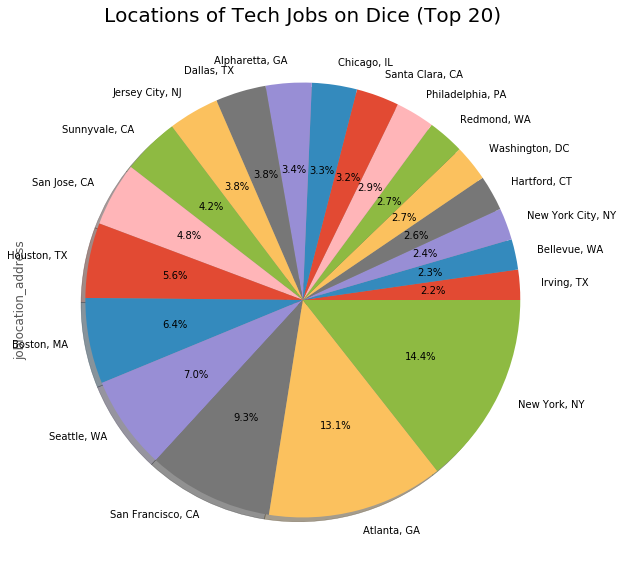

In [64]:
#Let's visualize the job location data with a pie chart
threshold = 10
location_value_counts = dice['joblocation_address'].astype(str).value_counts()[:20]
to_remove = location_value_counts[location_value_counts <= threshold].index
dice['joblocation_address'].replace(to_remove, np.nan, inplace=True)
location_value_counts = dice['joblocation_address'].astype(str).value_counts()[:20]
location_value_counts = location_value_counts[::-1]

location_value_counts.plot.pie(figsize=(10, 10),autopct='%1.1f%%', shadow=True)
# add a suptitle
plt.title("Locations of Tech Jobs on Dice (Top 20)", fontsize=20)
# change xticks fontsize to 14
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# finally show the plot
plt.show()

In [65]:
# this part of the code cleans up the "job status column"
# intent is to come up wiht a frequency distribution of 
# full time vs. contract positions


df100 = dice

df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].astype(str , copy=False)


df100['employmenttype_jobstatus']= df100['employmenttype_jobstatus'].apply(lambda x: " ".join(x.split(",")))
df100['employmenttype_jobstatus'].head()  

freq_employtype = pd.Series(df100['employmenttype_jobstatus']).value_counts()[:50]
freq_employtype

# Get rid of duplicate words - such as "Full Time occuring two times"
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist


df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: ' '.join(unique_list( x.split() ) ) )

freq_employtype = pd.Series(df100['employmenttype_jobstatus']).value_counts()[:50]
freq_employtype

# Replace the "-" in Full-Time by " " & get rid of duplicates

df100.replace('-', ' ', regex=True , inplace = True)
df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: ' '.join(unique_list( x.split() ) ) )

freq_employtype = pd.Series(df100['employmenttype_jobstatus']).value_counts()[:50]
freq_employtype

# replace Full Time time Employee  by Full Time
df100.replace('Full Time time', 'Full Time', regex=True , inplace = True)
df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: ' '.join(unique_list( x.split() ) ) )

freq_employtype = pd.Series(df100['employmenttype_jobstatus']).value_counts()[:50]
freq_employtype



#df100.replace('Full Time Perm', 'Full Time Permanent', regex=True , inplace = True)

freq_employtype = pd.Series(df100['employmenttype_jobstatus']).value_counts()[:50]
freq_employtype

# replace - Full Time Perm with Full Time Permanent -- need exact binary replacement cannot use .replace
# replace
#Full Time Perm
#Full Time Perm
#Full Time Long Term
#Full Time permanent
# with "Full Time Permanent"

df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: re.sub(r'\bFull Time Perm\b', 'Full Time Permanent', x))
df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: re.sub(r'\bFull Time permanent\b', 'Full Time Permanent', x))
df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: re.sub(r'\bFull Time perm\b', 'Full Time Permanent', x))
df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: re.sub(r'\bFull Time Long Term\b', 'Full Time Permanent', x))

# replace with - Full Time -- need exact binary replacement cannot use .replace
#Full Time Fulltime
#Full Time FTE
#Full Time FULLTIME 
#Full Time full time
#Full Time Employee
df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: re.sub(r'\bFull Time Fulltime\b', 'Full Time', x))
df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: re.sub(r'\bFull Time FTE\b', 'Full Time', x))
df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: re.sub(r'\bFull Time FULLTIME\b', 'Full Time', x))
df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: re.sub(r'\bFull Time full time\b', 'Full Time', x))
df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: re.sub(r'\bFull Time Employee\b', 'Full Time', x))
df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: re.sub(r'\bFull Time fulltime\b', 'Full Time', x))
# count Full Time Permanent also as Full Time
df100['employmenttype_jobstatus'] = df100['employmenttype_jobstatus'].apply(lambda x: re.sub(r'\bFull Time Permanent\b', 'Full Time', x))


# Handle the column JobLocation

#split the Joblocation_address column into city & state
column_nm = 'joblocation_address'
df100[column_nm] = df100[column_nm].astype(str , copy=False)
df100[column_nm].head(10)
df100['City'] = df100[column_nm].apply(lambda x: x.rpartition(',')[0])
df100['State'] = df100[column_nm].apply(lambda x: x.rpartition(',')[-1])
df100['Counter'] = 1

# find the mispelled states & delete the rows if there are not too many of them

list_states = ["GA", "DE","DC","WV","WI","HI","FL","WY","NH","NJ","NM","LA","TX","AK","NC","NE","ND","TN","NY","PA","RI","NV","CO","VA","AL","CA","AR","VT","IL","WA","IN","IA","MA","ID","AZ","CT","ME","MD","OK","OH","UT","MO","MN","MI","MT","KS","MS","SC","KY","OR","SD"]

df100['State'] = df100['State'].apply(lambda x: x.strip() if type(x)==str else x)
df100[~df100.State.isin(list_states)].count()

# Since there are only 129 entries out of 22K , we simply delete them
df100 = df100[df100.State.isin(list_states)]

#df100 dataframe contains only valid US states
# lets groupby the  top-cities with jobs
groupby_city = df100.groupby(['State', 'City'])
jobs_city = groupby_city.sum()

# Join Group_by dataframe uscities_longlat
new_df = pd.merge(jobs_city, uscities_longlat,  how='left', left_on=['City','State'], right_on = ['city','state_id'])


# drop the rows that do not have latitude or Longitude information
new_df = new_df.dropna(subset=['lat']) 
new_df = new_df.dropna(subset=['lng']) 
# now the new dataframe (new_df ) will be used for geomaps
# rename 'Count column to "Jobs"

new_df = new_df.rename(columns={"Counter": "Jobs"})
#reset the index
new_df = new_df.reset_index()
new_df['Country'] = 'US'
new_df.columns
new_df = new_df.rename(columns={"lat": "Latitude"})
new_df.columns
new_df = new_df.rename(columns={"lng": 'Longitude'})
new_df['Name'] = new_df['city'].astype(str)+', '+new_df['state_id'].astype(str)

df1 = new_df
df1['perc_job'] = df1['Jobs'].apply(lambda x: x / df1['Jobs'].sum())

# read the datafile with state population into a dataframe
df = pd.read_csv(datafile)
df1.columns

#map latitute  & Longitude as x & y from df1 (jobs dataframe)
geometry = geopandas.points_from_xy(df1.Longitude, df1.Latitude)
geo_df = geopandas.GeoDataFrame(df1[['Name', 'Country', 'Jobs' , 'Latitude', 'Longitude', 'perc_job']], geometry=geometry)

#geometry
#geo_df.drop([30])

#retain all rows as a backup
geo_df1 = geo_df

# Keep only top 15 cities for the plot
geo_df = geo_df.sort_values(['Jobs'], ascending=False).head(15)

cities = geo_df

gdf = geopandas.read_file(shapefile)[['iso_a2', 'name', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'state_name', 'geometry']
gdf.head(10)


#Drop row corresponding to 'Alaska'
idx = gdf[gdf['state_name'] == 'Alaska'].index
gdf = gdf.drop(gdf.index[idx])

#Drop row corresponding to 'Hawaii'
idx = gdf[gdf['state_name'] == 'Hawaii'].index
gdf = gdf.drop(gdf.index[idx])


df['percent1'] = df['percent'].apply(lambda x: x*100)
df['population'] = df['population'].astype(float)
df['population'] = df['population'].apply(lambda x: x/1000000)
df['population'] = df['population'].apply(lambda x: '{:,.1f}MM'.format(x))

#Merge dataframes gdf and uscities
merged = gdf.merge(df, left_on = 'state_name', right_on = 'state_name')


#Read data to json.
merged_json = json.loads(merged.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)


#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette_cirle = brewer['YlGnBu'][4]
#palette_cirle = brewer['PuBuGn'][8]
#palette = brewer['Blues'][4]
#Reverse color order so that dark blue is highest population
palette_cirle = palette_cirle[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.

#color_mapper_circle = LinearColorMapper(palette = palette_cirle , low = 0, high = .15)

#color_mapper = LogColorMapper(palette = palette, low = 0, high = 15)

#Define custom tick labels for color bar.
tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '>40%'}


#Create color bar. 
#color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
#border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

#
hover = HoverTool(tooltips = [ ('State','@state_name'),('% Population', '@percent1') , ('Population','@population')])
#hover = HoverTool(tooltips = [ ('State','@s1'),('% Jobs', '@perc_job') , ('Population','@population')])
#hover1 = HoverTool(tooltips = [ ('State','@state_name'),('% Population', '@percent') , ('Population','@population')])

#Create figure object.
p = figure(title = '"National Snapshot - Top cities by Tech Job postings(Total job postings = 19,252)', plot_height = 600 , plot_width = 1000, toolbar_location = None , tools=[hover] )


p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None


p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
#p.patches('xs','ys', source = geosource,fill_color = {'field' :'percent1', 'transform' : color_mapper},
#          line_color = 'black', line_width = 0.25, fill_alpha = 1)

# Plot the state boundaries
p.patches('xs','ys', source = geosource,fill_color = '#F5F5F5',
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#p.scatter(x ,y,  fill_color =  'blue' ,  radius= radii ,  line_width=0, alpha=0.7)

x = cities['Longitude']
y = cities['Latitude']
s1 = cities['Name'] + ":" + cities['Jobs'].astype(str)
size = cities['Jobs']/10
z = cities['Jobs']/25
#Use the field name of the column source
mapper = linear_cmap(field_name='z', palette=palette_cirle,low=min(z) ,high=max(z))

source = ColumnDataSource(dict(x=x, y=y, z=z ))

#p = figure(plot_width=1050, plot_height= 600, title="Linear Color Map Based on Y")
p.circle(x='x', y='y', line_color=mapper,color=mapper, fill_alpha=1, size= 'z', source=source)

#color_bar = ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0))





#border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
#p.add_layout(color_bar, 'right')

exclude = ( 'Seattle, WA' , 'Atlanta, GA' , 'San Jose, CA' , 'Sunnyvale, CA' , 'Santa Clara, CA' , 'Jersey City, NJ')
cities1 = cities[~cities.Name.isin(exclude)]


x = cities1['Longitude']
y = cities1['Latitude']
s1 = cities1['Name'] + ":" + cities1['Jobs'].astype(str)
per_color = cities1['perc_job']
radii = cities1['perc_job']*15

#for label, xpt, ypt, x_offset, y_offset in zip(labels, x, y, x_offsets, y_offsets):
#    p.text(xpt+x_offset, ypt+y_offset, label)

p.text(x , y , text=s1, text_color="black", text_align="left", text_font_size="11pt")

exclude = ( 'Seattle, WA' , 'Atlanta, GA')
cities1 = cities[cities.Name.isin(exclude)]
     
x = cities1['Longitude']
y = cities1['Latitude']
s1 = cities1['Name'] + ":" + cities1['Jobs'].astype(str)
per_color = cities1['perc_job']
radii = cities1['perc_job']*15

#for label, xpt, ypt, x_offset, y_offset in zip(labels, x, y, x_offsets, y_offsets):
#    p.text(xpt+x_offset, ypt+y_offset, label)

p.text(x , y-.7 , text=s1, text_color="black", text_align="left", text_font_size="11pt")
    

exclude = ('San Jose, CA' ,  'Jersey City, NJ')
cities1 = cities[cities.Name.isin(exclude)]
     
x = cities1['Longitude']
y = cities1['Latitude']
s1 = cities1['Name'] + ":" + cities1['Jobs'].astype(str)
per_color = cities1['perc_job']
radii = cities1['perc_job']*15

#for label, xpt, ypt, x_offset, y_offset in zip(labels, x, y, x_offsets, y_offsets):
#    p.text(xpt+x_offset, ypt+y_offset, label)

p.text(x , y-1.5, text=s1, text_color="black", text_align="left", text_font_size="11pt")    


exclude = ( 'Santa Clara, CA' , 'Tes b')
cities1 = cities[cities.Name.isin(exclude)]
     
x = cities1['Longitude']
y = cities1['Latitude']
s1 = cities1['Name'] + ":" + cities1['Jobs'].astype(str)
per_color = cities1['perc_job']
radii = cities1['perc_job']*15

#for label, xpt, ypt, x_offset, y_offset in zip(labels, x, y, x_offsets, y_offsets):
#    p.text(xpt+x_offset, ypt+y_offset, label)

p.text(x , y+ 2.5, text=s1, text_color="black", text_align="left", text_font_size="11pt") 

# have to prevent the lables from overlap
exclude = ('Sunnyvale, CA' , 'Test a')
cities1 = cities[cities.Name.isin(exclude)]  
x = cities1['Longitude']
y = cities1['Latitude']
s1 = cities1['Name'] + ":" + cities1['Jobs'].astype(str)
per_color = cities1['perc_job']
radii = cities1['perc_job']*15

#for label, xpt, ypt, x_offset, y_offset in zip(labels, x, y, x_offsets, y_offsets):
#    p.text(xpt+x_offset, ypt+y_offset, label)

p.text(x , y+ 1.6, text=s1, text_color="black", text_align="left", text_font_size="11pt") 
    
    
output_notebook()
#Display figure.
show(p)


Loading BokehJS ...

In [66]:
#The same method should be applied to the company column as well
dice['company'].astype(str).value_counts()[:20]
#Amazon seems to be a big employer; It's the first tech company that comes up. 
#There are also staffing companies like CyberCoders, Robert Half and kforce posting jobs on behalf of other companies. 
#Deloitte is also a top hit, which is surprising because many people think of it more as an accounting/consulting company. 

CyberCoders                 335
Amazon                      263
Robert Half                 249
Robert Half Technology      247
U.S. Tech Solutions Inc.    188
Collabera                   178
Visionaire Partners         171
Kforce Inc.                 161
The Judge Group             157
Apex Systems, Inc           151
Net2Source Inc.             139
Modis                       139
Deloitte                    138
Randstad Technologies       132
TEKsystems, Inc.            108
NORTHROP GRUMMAN             95
Maxonic, Inc.                92
RSM US                       92
Experis                      84
Access Staffing              83
Name: company, dtype: int64

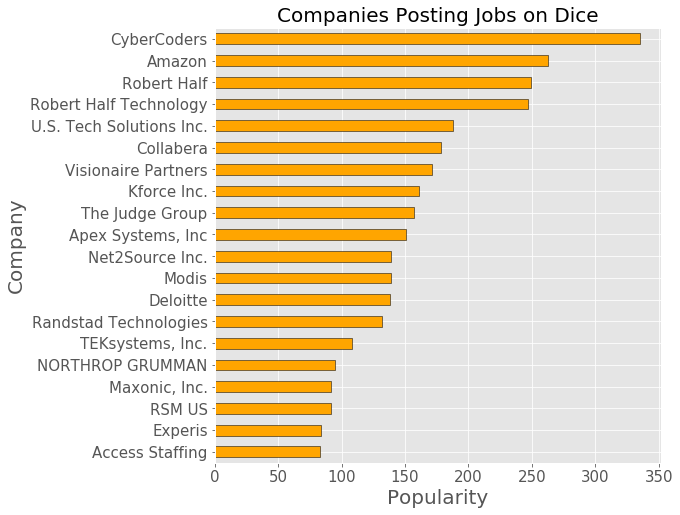

In [67]:
#Let's visualize the company data 
threshold = 10
location_value_counts = dice['company'].astype(str).value_counts()[:20]
to_remove = location_value_counts[location_value_counts <= threshold].index
dice['company'].replace(to_remove, np.nan, inplace=True)
location_value_counts = dice['company'].astype(str).value_counts()[:20]
location_value_counts = location_value_counts[::-1]

location_value_counts.plot.barh(figsize=(8, 8),color = 'orange',edgecolor = 'black')
# add a suptitle
plt.title("Companies Posting Jobs on Dice", fontsize=20)
# set xlabel to ""
plt.xlabel("Popularity", fontsize=20)
plt.ylabel("Company",fontsize=20)
# change xticks fontsize to 14
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# finally show the plot
plt.show()

In [68]:
#Subset by Company 'contains' Amazon
df_amazon  = dice.loc[ dice['company'].str.contains('Amazon' , na=False)]

# apply the cool function to get the most frequent words
#coolfunction(df_amazon['jobdescription'],0, 50)

# apply the cool function to get the most frequent words
amazon_freq_jobdesc =  coolfunction(df_amazon['jobdescription'],0, 50)
remove_words = ('experience' , 'software' , 'amazon' , 'qualifications' , 'work' , 'skills')

df300 = pd.DataFrame(data=amazon_freq_jobdesc)
df300.rename(columns={ df300.columns[0]: "Frequency" }, inplace = True)
df300 = df300.reset_index()
df300 =  df300[df300["index"] != 'experience']
df300 = df300[df300["index"] != 'amazon']
df300 = df300[~df300['index'].isin( remove_words)]
remove_more_words = ('team', 'development', 'business', 'data', 'technical', 'systems', 'computer', 'teams', 'years', 'build', 'customer', 'new', 'strong', 'ability', 'building', 'degree', 'preferred', 'knowledge', 'date', 'basic', 'working', 'products', 'solutions', 'posted', 'high', 'service', 'across', 'role', 'related' )

df300 =  df300[~df300['index'].isin( remove_more_words)]
df300



,index,Frequency
7,services,571
13,customers,466
14,design,428
15,product,421
20,science,389
21,management,381
23,engineering,369
25,aws,363
29,web,328
34,engineers,264


In [69]:
#Most of the job title 
dice['jobtitle'].astype(str).value_counts()[:10]

Java Developer           174
Project Manager          145
Network Engineer         128
Software Engineer        118
Business Analyst         117
.Net Developer            70
DevOps Engineer           60
Systems Engineer          55
Systems Administrator     54
Web Developer             53
Name: jobtitle, dtype: int64

In [70]:
dice['jobtitle'].astype(str).value_counts()[:10]

Java Developer           174
Project Manager          145
Network Engineer         128
Software Engineer        118
Business Analyst         117
.Net Developer            70
DevOps Engineer           60
Systems Engineer          55
Systems Administrator     54
Web Developer             53
Name: jobtitle, dtype: int64

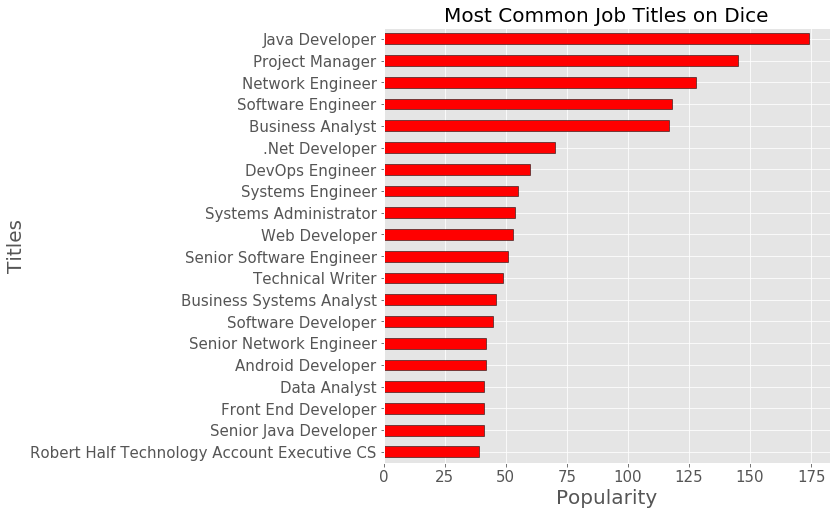

In [71]:
#Let's visualize the job title data 
threshold = 10
location_value_counts = dice['jobtitle'].astype(str).value_counts()[:20]
to_remove = location_value_counts[location_value_counts <= threshold].index
dice['jobtitle'].replace(to_remove, np.nan, inplace=True)
location_value_counts = dice['jobtitle'].astype(str).value_counts()[:20]
location_value_counts = location_value_counts[::-1]

location_value_counts.plot.barh(figsize=(8, 8),color = 'red',edgecolor = 'black')
# add a suptitle
plt.title("Most Common Job Titles on Dice", fontsize=20)
# set xlabel to ""
plt.xlabel("Popularity", fontsize=20)
plt.ylabel("Titles",fontsize=20)
# change xticks fontsize to 14
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# finally show the plot
plt.show()

In [72]:
#Full time jobs are the most common type of job posting on Dice. 
dice['employmenttype_jobstatus'].astype(str).value_counts()[:10]

Full Time                                        9139
Contract W2                                      1123
Contract Corp To Independent W2                   633
Contract Corp To Independent W2 C2H               596
C2H W2                                            302
Contract Corp To                                  270
nan                                               230
Full Time Contract Corp To Independent W2 C2H     214
Contract Corp To W2                               206
Contract Independent W2                           183
Name: employmenttype_jobstatus, dtype: int64

In [73]:
#Although it would have been interesting to do a times series to see 
#how the contents of each column changed over several years, if we look at 
#the job posting date, we can see that all of these job postings are from the 
#same year.
dice['postdate'].astype(str).value_counts()[:10]

2 weeks ago    3149
2 days ago     2459
3 days ago     2393
1 week ago     2148
4 days ago     1803
3 weeks ago    1181
1 day ago       739
5 hours ago     675
7 hours ago     601
2 hours ago     488
Name: postdate, dtype: int64

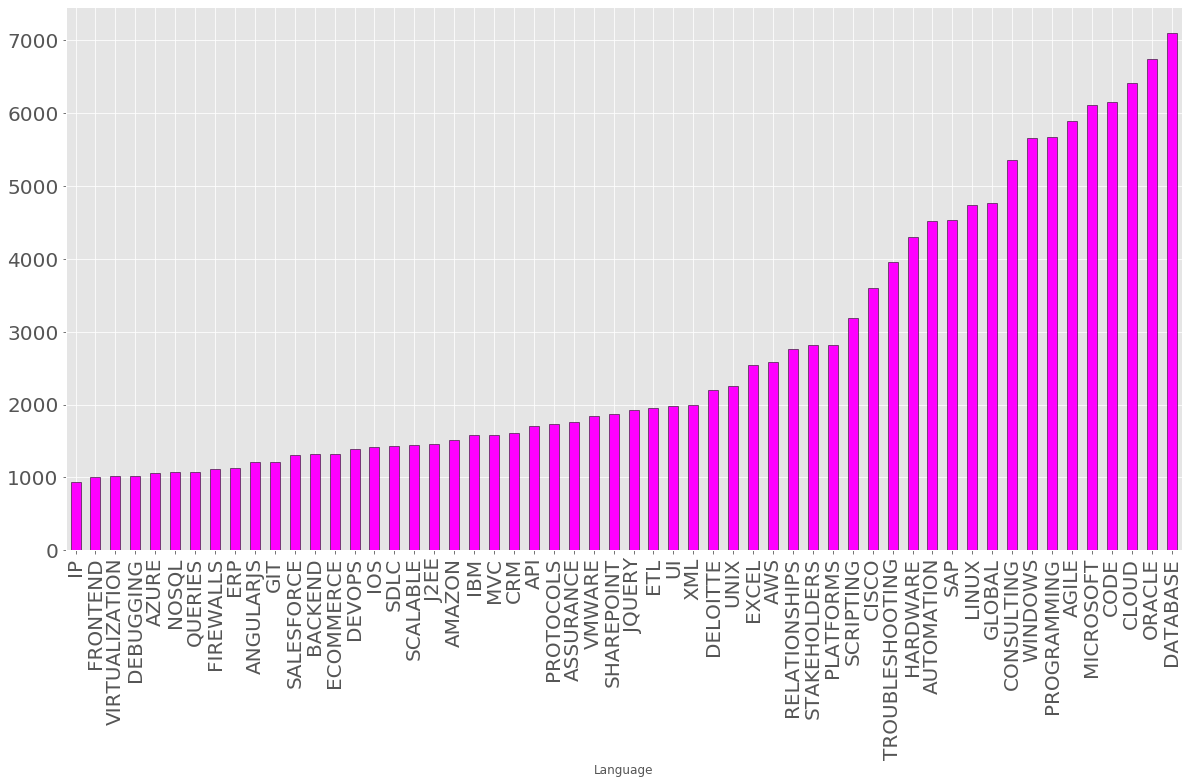

In [74]:
#Visializing notable words in the dice dataset (ex-programming languages)
#Omitted first 50 words because they were too generic 

languages_list = ['database','code','cloud','oracle','microsoft' ,'agile','consulting','programming','windows','global','automation','sap'
,'hardware','troubleshooting','linux','cisco','stakeholders','scripting','platforms','relationships','deloitte' ,'aws','excel','ui' 
,'unix' ,'sharepoint' ,'etl' ,'xml' ,'assurance' ,'protocols','vmware','amazon','scalable','jquery','ibm','crm','api','devops'
,'backend','ecommerce' ,'ios','salesforce','mvc','sdlc','j2ee' ,'queries','firewalls' ,'frontend','debugging','erp','git','virtualization','azure' 
,'angularjs','ip' ,'nosql']
qualifications = dice['jobdescription'].tolist()+dice['skills'].tolist()
qualstring = "".join(re.sub('[·,-/’()]', '', str(v)) for v in qualifications).lower()
wordcount = dict((x,0) for x in languages_list)
for w in re.findall(r"[[\w'+#-]+|[.!?;’]", qualstring):
    if w in wordcount:
        wordcount[w] += 1
popularity = sorted(wordcount.items(), key=lambda kv: kv[1],reverse=True)
lang = pd.DataFrame(popularity,columns=['Language','Popularity'])
lang['Language'] = lang.Language.str.upper()
lang = lang[::-1]
lang.plot.bar(x='Language',y='Popularity',figsize=(20,10), 
              legend=False,color = 'magenta',fontsize = 20,edgecolor = 'black')

In [75]:
#Going beyond the dice dataset. 

#Now that we developed NLP methods, we can easily clean and analyze other datasets. 
#Below we looked at the google jobs dataset. 
google[:10]

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin..."
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...
3,Google,"Developer Advocate, Partner Engineering",Developer Relations,"Mountain View, CA, United States","Work one-on-one with the top Android, iOS, and...",BA/BS degree in Computer Science or equivalent...,"Experience as a software developer, architect,..."
4,Google,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Sunnyvale, CA, United States",Plan requirements with internal customers.\nPr...,BA/BS degree or equivalent practical experienc...,CTS Certification.\nExperience in the construc...
5,Google,"Associate Account Strategist (Czech/Slovak), G...",Technical Solutions,"Dublin, Ireland",Communicate with customers via phone and email...,Bachelor's degree or equivalent practical expe...,"Experience in sales, customer service, account..."
6,Google,"Supplier Development Engineer, Camera, Consume...",Hardware Engineering,"Mountain View, CA, United States",Manage cross-functional activities in the supp...,BS degree in Engineering or equivalent practic...,Master's degree.\nExperience in the developmen...
7,Google,"Strategic Technology Partner Manager, Healthca...",Partnerships,"Sunnyvale, CA, United States",Lead the development and strategy with partner...,BA/BS degree or equivalent practical experienc...,"BA/BS degree in a technical, life sciences or ..."
8,Google,"Manufacturing Business Manager, Google Hardware",Manufacturing & Supply Chain,"Xinyi District, Taiwan",Develop CM/ODM strategy and implement supplier...,"BA/BS degree in Engineering, Supply Chain or e...",MBA degree.\nExperience in procurement and sup...
9,Google,"Solutions Architect, Healthcare and Life Scien...",Technical Solutions,"New York, NY, United States",Help compile customer requirements as well as ...,"BA/BS degree in Computer Science, related Soft...","Master's degree in Computer Science, related E..."


In [76]:
#It's suprising how many sales jobs google has. 
google['Category'].astype(str).value_counts()[:10]

Sales & Account Management    168
Marketing & Communications    165
Finance                       115
Technical Solutions           101
Business Strategy              98
People Operations              86
User Experience & Design       84
Program Management             74
Partnerships                   60
Product & Customer Support     50
Name: Category, dtype: int64

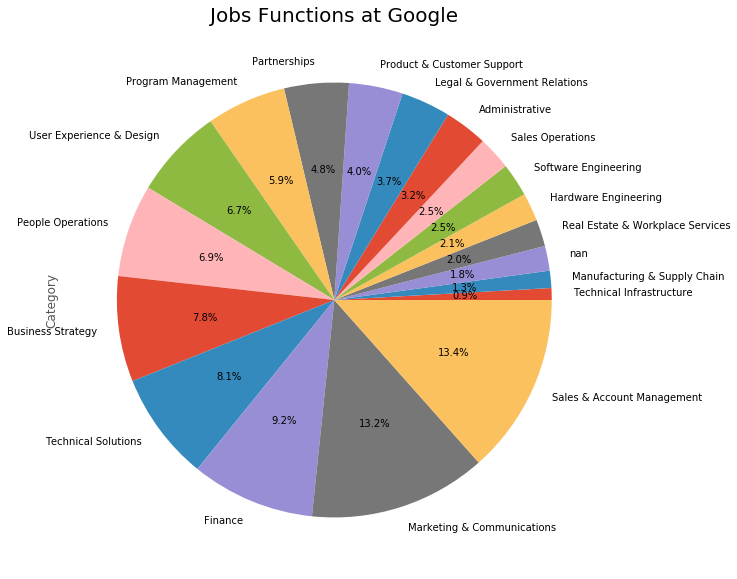

In [77]:
#Let's visualize this data 
threshold = 10
location_value_counts = google['Category'].astype(str).value_counts()
to_remove = location_value_counts[location_value_counts <= threshold].index
google['Category'].replace(to_remove, np.nan, inplace=True)
location_value_counts = google['Category'].astype(str).value_counts()
location_value_counts = location_value_counts[::-1]

location_value_counts.plot.pie(figsize=(10, 10),autopct='%1.1f%%')

# add a suptitle
plt.title("Jobs Functions at Google", fontsize=20)

# finally show the plot
plt.show()

In [78]:
#Google has lots of MBA summer internship job postings! 
google['Title'].astype(str).value_counts()[:10]

Business Intern 2018                          35
MBA Intern, Summer 2018                       34
MBA Intern 2018                               28
BOLD Intern, Summer 2018                      21
Field Sales Representative, Google Cloud      17
Interaction Designer                          12
User Experience Researcher                     9
User Experience Design Intern, Summer 2018     7
Partner Sales Engineer, Google Cloud           7
Recruiter                                      7
Name: Title, dtype: int64

In [79]:
#This is to be expected, but most of the google jobs are in California. 
google['Location'].astype(str).value_counts()[:10]

Mountain View, CA, United States    190
Sunnyvale, CA, United States        155
Dublin, Ireland                      87
New York, NY, United States          70
London, United Kingdom               62
San Francisco, CA, United States     49
Singapore                            41
Sydney, Australia                    31
Tokyo, Japan                         31
San Bruno, CA, United States         28
Name: Location, dtype: int64

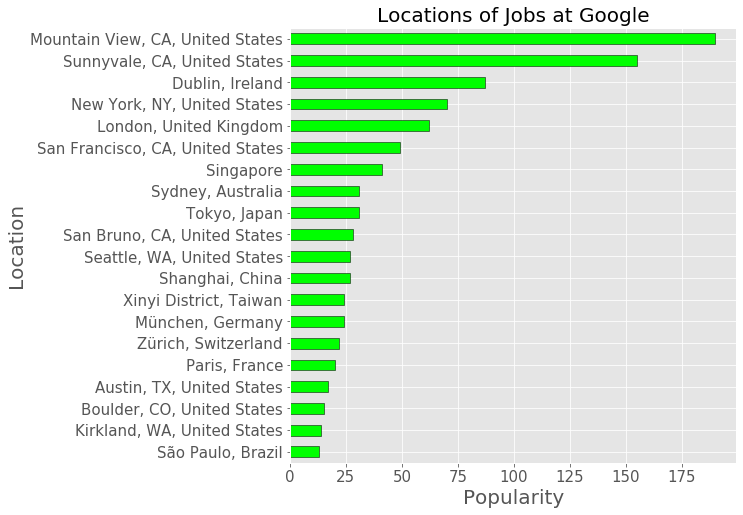

In [80]:
#Let's visualize this data 
threshold = 10
location_value_counts = google['Location'].astype(str).value_counts()[:20]
to_remove = location_value_counts[location_value_counts <= threshold].index
google['Location'].replace(to_remove, np.nan, inplace=True)
location_value_counts = google['Location'].astype(str).value_counts()[:20]
location_value_counts = location_value_counts[::-1]

location_value_counts.plot.barh(figsize=(8, 8),color = 'lime',edgecolor = 'black')
# add a suptitle
plt.title("Locations of Jobs at Google", fontsize=20)
# set xlabel to ""
plt.xlabel("Popularity", fontsize=20)
plt.ylabel("Location",fontsize=20)
# change xticks fontsize to 14
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# finally show the plot
plt.show()

In [81]:
coolfunction(google['Responsibilities'],0,50)

business           1207
google              998
product             928
teams               787
develop             774
work                751
team                634
partners            628
technical           601
manage              592
customer            503
support             484
provide             477
drive               472
partner             472
sales               458
management          437
customers           431
cloud               425
including           399
strategic           383
new                 383
marketing           381
data                374
identify            373
solutions           362
design              359
build               358
lead                352
development         344
opportunities       344
strategy            342
products            338
across              337
ensure              326
internal            318
key                 301
engineering         292
relationships       290
projects            289
googles             279
performance     

In [82]:
coolfunction(google['Preferred Qualifications'],0,50)

experience        2306
ability           1856
skills            1460
management         714
business           677
demonstrated       640
excellent          570
work               543
communication      528
environment        520
strong             472
analytical         444
working            440
technical          436
data               372
knowledge          371
technology         357
cloud              353
sales              347
understanding      326
effective          323
degree             309
project            306
interpersonal      286
complex            285
design             284
marketing          273
related            270
organizational     256
customer           249
written            249
teams              249
strategic          249
relationships      245
multiple           244
andor              241
technologies       239
analysis           237
team               231
projects           226
including          223
industry           222
interest           216
systems    

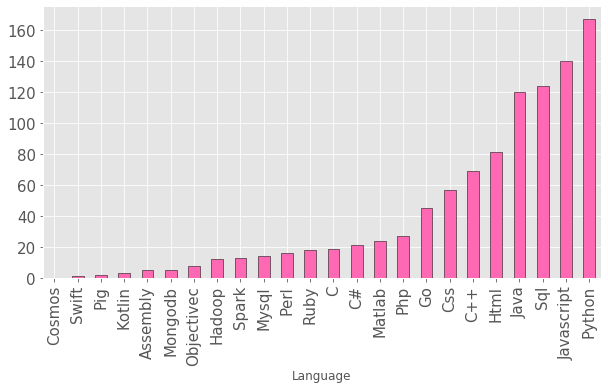

In [83]:
#Looks like Python is the most popular programming language at Google! 
#What we are learning is very relevant! 
languages_list = ['swift','matlab','mongodb','assembly','hadoop','cosmos', 'mysql','go','css','spark', 'pig', 'kotlin','sql','html','python', 'java', 'c++', 'php', 'javascript', 'objectivec', 'ruby', 'perl','c','c#']
qualifications = google['Responsibilities'].tolist()+google['Minimum Qualifications'].tolist()+google['Preferred Qualifications'].tolist()
qualstring = "".join(re.sub('[·,-/’()]', '', str(v)) for v in qualifications).lower()
wordcount = dict((x,0) for x in languages_list)
for w in re.findall(r"[[\w'+#-]+|[.!?;’]", qualstring):
    if w in wordcount:
        wordcount[w] += 1
popularity = sorted(wordcount.items(), key=lambda kv: kv[1],reverse=True)
lang = pd.DataFrame(popularity,columns=['Language','Popularity'])
lang['Language'] = lang.Language.str.capitalize()
lang = lang[::-1]
lang.plot.bar(x='Language',y='Popularity',figsize=(10,5), legend=False, color = 'hotpink',fontsize = 15,edgecolor = 'black')

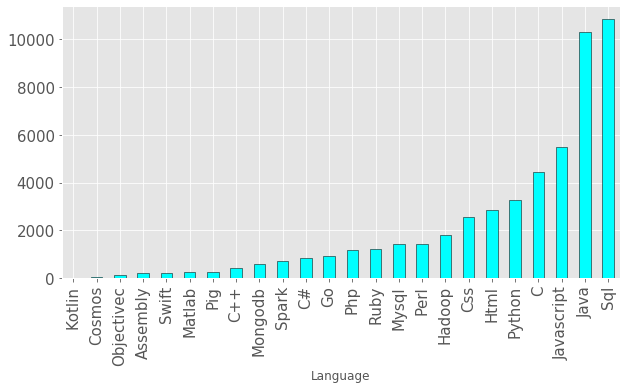

In [84]:
#In contrast, if you looks at tech jobs generally (as defined as jobs in the dice dataset),
#you can see that SQL, Java and Javascript are the most popular, followed by Python. 
languages_list = ['swift','matlab','mongodb','assembly','hadoop','cosmos', 'mysql','go','css','spark', 'pig', 'kotlin','sql','html','python', 'java', 'c++', 'php', 'javascript', 'objectivec', 'ruby', 'perl','c','c#']
qualifications = dice['jobdescription'].tolist()+dice['skills'].tolist()+dice['jobtitle'].tolist()
qualstring = "".join(re.sub('[·,-/’()]', '', str(v)) for v in qualifications).lower()
wordcount = dict((x,0) for x in languages_list)
for w in re.findall(r"[[\w'+#-]+|[.!?;’]", qualstring):
    if w in wordcount:
        wordcount[w] += 1
popularity = sorted(wordcount.items(), key=lambda kv: kv[1],reverse=True)
lang = pd.DataFrame(popularity,columns=['Language','Popularity'])
lang['Language'] = lang.Language.str.capitalize()
lang = lang[::-1]
lang.plot.bar(x='Language',y='Popularity',figsize=(10,5), legend=False, color = 'aqua',fontsize = 15,edgecolor = 'black')